In [ ]:
!pip install bayesian-optimization

In [ ]:
import numpy      as np
import pandas     as pd
import matplotlib.pyplot as plt
import seaborn    as sns
from   zipfile    import ZipFile
from   datetime   import datetime
import random
import re
import time

from sklearn.ensemble         import RandomForestClassifier
from sklearn.model_selection  import train_test_split
from sklearn.metrics          import accuracy_score

from bayes_opt                import BayesianOptimization
from sklearn.model_selection  import cross_val_score, StratifiedKFold
from sklearn.metrics          import accuracy_score, make_scorer, roc_auc_score, log_loss
from sklearn.utils            import class_weight
from xgboost                  import XGBClassifier

import xgboost    as xgb
import tensorflow as tf

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle          # Making New File Directory
!cp kaggle.json ~/.kaggle/ # New File Path
! chmod 600 ~/.kaggle/kaggle.json  ## Permission

In [ ]:
!kaggle datasets download -d jackdaoud/marketing-data

  0% 0.00/643k [00:00<?, ?B/s]
100% 643k/643k [00:00<00:00, 18.6MB/s]


In [ ]:
with ZipFile('marketing-data.zip') as zip_file:
  print(zip_file.namelist())
  with zip_file.open(zip_file.namelist()[1]) as csv:
    data  = pd.read_csv(csv)

data

['dictionary.png', 'ifood_df.csv']


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,61223.0,0,1,46,709,43,182,42,118,247,...,0,0,0,0,1,0,0,1094,847,0
2201,64014.0,2,1,56,406,0,30,0,0,8,...,1,0,0,0,0,0,1,436,428,1
2202,56981.0,0,0,91,908,48,217,32,12,24,...,0,0,0,0,1,0,0,1217,1193,1
2203,69245.0,0,1,8,428,30,214,80,30,61,...,1,0,0,0,0,1,0,782,721,0


**PreDataSet Checks**
1. Check if any values are missing
2. Check the types of variables (categorical vs continuous)


In [ ]:
def is_categorical(df, threshold=0.05):

    """
    Checks if columns in a DataFrame are categorical.

    Parameters:
    - df: The input DataFrame.
    - threshold: Proportion of unique values to total rows for numeric columns
                 to be considered categorical.

    Returns:
    - A dictionary where keys are column names and values are boolean
      indicating if the column is categorical.
    """


    categorical       = {}
    non_categorical   = {}
    for col in df.columns:
        # If dtype is object or category, it's categorical
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            categorical[col] = True
        # For numeric types, check the proportion of unique values
        elif (df[col].nunique() / len(df)) < threshold:
            categorical[col] = True
        else:
            non_categorical[col] = False


    return categorical, non_categorical

# Example Usage:

categorical, non_categorical = is_categorical(data)


In [ ]:
categorical.keys()

In [ ]:
non_categorical.keys()

**SPlit up Datasets**

In [ ]:
[data[col].value_counts() for col in data[['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response']]]

In [ ]:
education_levels = ['education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'Response']

def analyze_correlation(subset, nrows = 2, ncols = 3, figsize = (15, 10), add_percentage = False):
  education_df = data[subset]

  target_column = 'Response'

  def add_percentages(ax, df, feature):
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center")


  # Plotting
  variables_to_compare = education_df[education_df.columns[:-1]]  # Add your variables here
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

  for var, ax in zip(variables_to_compare, axes.ravel()):
      sns.countplot(data=education_df, x=var, hue='Response', ax=ax, palette='Blues_d')
      ax.set_title(f'Target Distribution by {var}')
      ax.legend(title='Target', labels=['False', 'True'])
      if add_percentage:
        add_percentages(ax, education_df, var)


  plt.tight_layout()
  plt.show()


  return


analyze_correlation(education_levels, add_percentage = True)

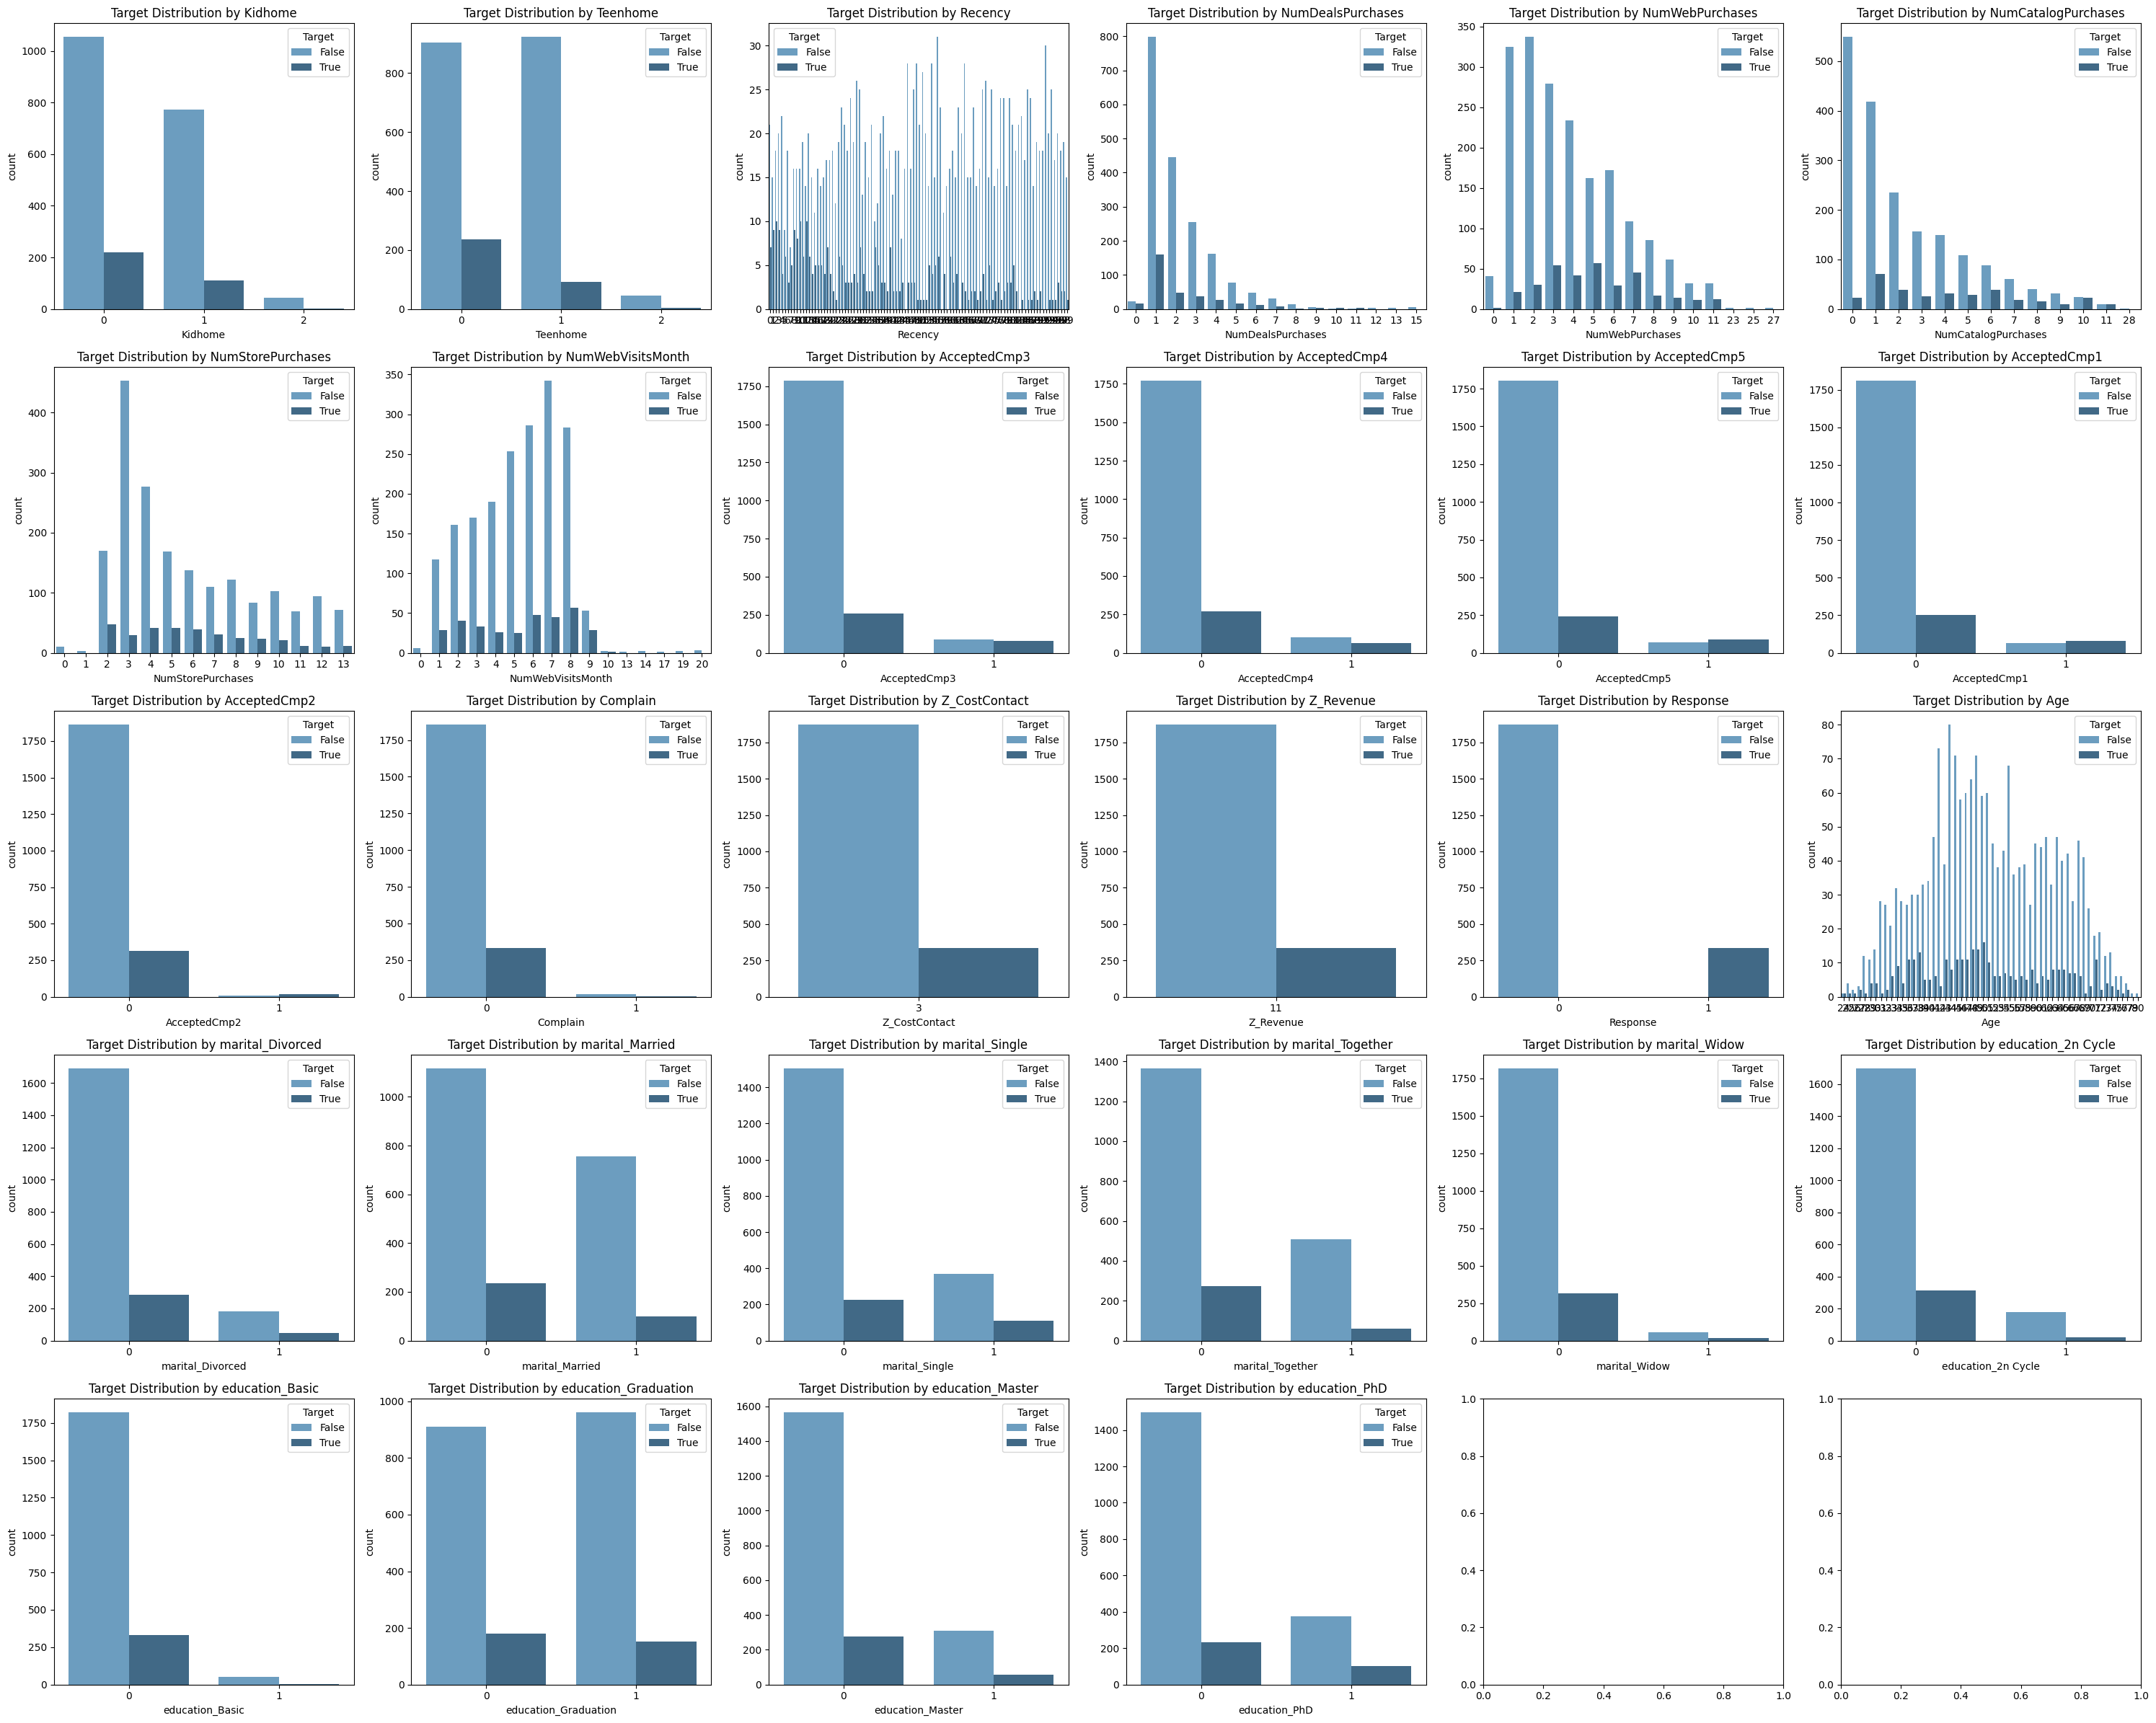

In [ ]:
analyze_correlation(list(categorical.keys()), nrows = 5, ncols = 6, figsize = (30, 24))

**Use Response as Target**
1. Drop all other variables that provide leakage into information on response (accepted campain variables)

In [ ]:
targets                     = data['Response']
leakage_variables           = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                               'AcceptedCmp1', 'AcceptedCmp2']

x_data  = data.drop(columns = ['AcceptedCmpOverall', 'Response'] + leakage_variables)

x_train, x_test, y_train, y_test = train_test_split(x_data, targets, random_state = 42)

**Barplot of Accepted Campain vs Did not Accept**

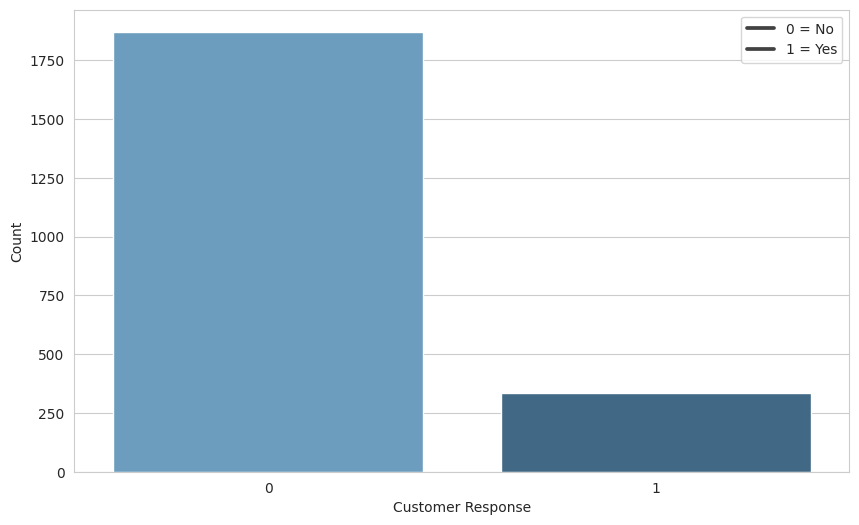

In [ ]:
# Set style
sns.set_style("whitegrid")

# Create bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=targets.value_counts().index, y=list(targets.value_counts()), palette="Blues_d")

# Title and labels
plt.xlabel('Customer Response')
plt.ylabel('Count')
plt.legend(['0 = No', '1 = Yes'])

# Display the plot
plt.show()

**BaseLine Model**
1. Based off the all columns in the table, this model predicts ~86% of the correct classification for if a customer will buy or not

In [ ]:
def create_xgb(x_train, y_train):

  xgb_model = XGBClassifier()
  xgb_model.fit(x_train, y_train)

  return xgb_model

xgb_model   = create_xgb(x_train, y_train)
predictions = xgb_model.predict(x_test)
accuracy_score(predictions, y_test)

0.8713768115942029

In [ ]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.3 MB/s eta 0:00:00


In [ ]:
# Seeing How boruta_py behaves
from boruta import BorutaPy

def boruta_py(targets):
  forest     = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

  # Define Boruta feature selection method
  boruta_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=42)

  # Find relevant features
  boruta_selector.fit(np.array(x_train), np.array(targets))

  # Check selected features
  selected_features = np.where(boruta_selector.support_)[0]
  print(f"Selected features: {selected_features}")

  # Optionally, you can transform the dataset to only include selected features:
  X_filtered             = boruta_selector.transform(np.array(x_train))
  x_test_transformed     = boruta_selector.transform(np.array(x_test))

  xgb_model.fit(X_filtered, targets)


  return xgb_model

xgb_model = boruta_py(y_train)

**Using Borutapy's Selected Features and Reducing Dataset**

In [ ]:
selected_features = [0, 3, 4, 5, 6, 9, 11, 12, 13, 14, 19, 30, 31]
x_data_reduced    = x_data[x_data.columns[selected_features]]
x_data_reduced

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_Days,MntTotal,MntRegularProds
0,58138.0,58,635,88,546,88,8,10,4,7,2822,1529,1441
1,46344.0,38,11,1,6,6,1,1,2,5,2272,21,15
2,71613.0,26,426,49,127,42,8,2,10,4,2471,734,692
3,26646.0,26,11,4,20,5,2,0,4,6,2298,48,43
4,58293.0,94,173,43,118,15,5,3,6,5,2320,407,392
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,61223.0,46,709,43,182,247,9,3,4,5,2540,1094,847
2201,64014.0,56,406,0,30,8,8,2,5,7,2178,436,428
2202,56981.0,91,908,48,217,24,2,3,13,6,2314,1217,1193
2203,69245.0,8,428,30,214,61,6,5,10,3,2315,782,721


**Correlation Matirx Heatmap**

<Axes: >

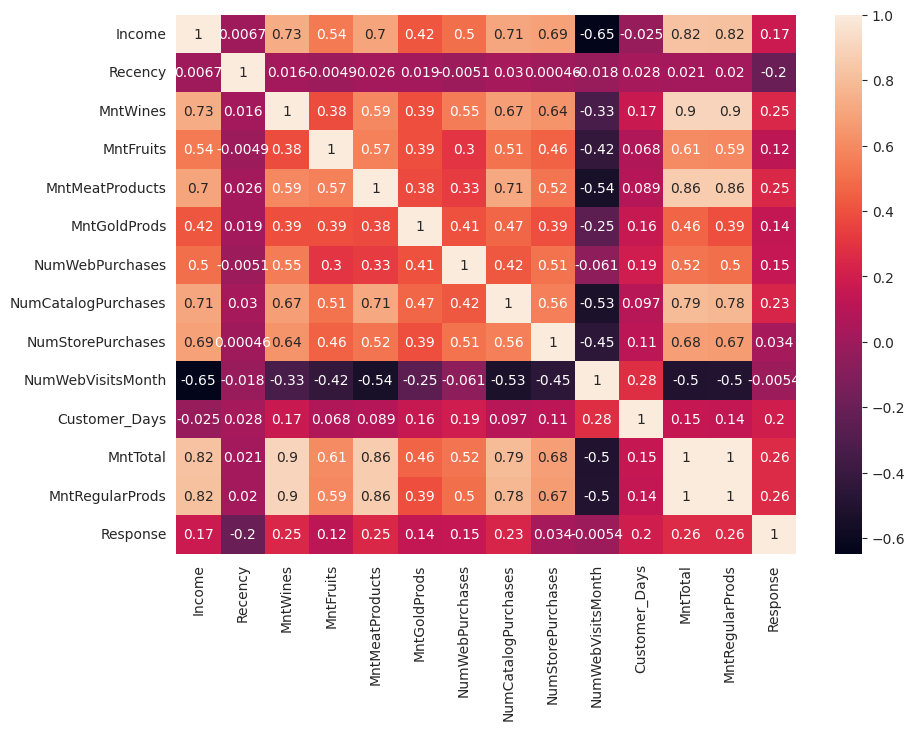

In [ ]:
data_rejoined = pd.concat([x_data_reduced, targets], axis = 1)
figure = plt.figure(figsize = (10, 7))
sns.heatmap(data_rejoined.corr(), annot = True)

**Analyze Performance of New Model with Reduced Features**

In [ ]:
def create_xgb(x_train, y_train):

  xgb_model = XGBClassifier()
  xgb_model.fit(x_train, y_train)

  return xgb_model


x_train, x_test, y_train, y_test = train_test_split(x_data_reduced, targets, random_state = 42)
xgb_model     = create_xgb(x_train, y_train)


predictions   = xgb_model.predict(x_test)
accuracy_score(predictions, y_test)

0.8659420289855072

**XGBoost Model Importance Plot**

Text(0.5, 1.0, 'Feature Importance')

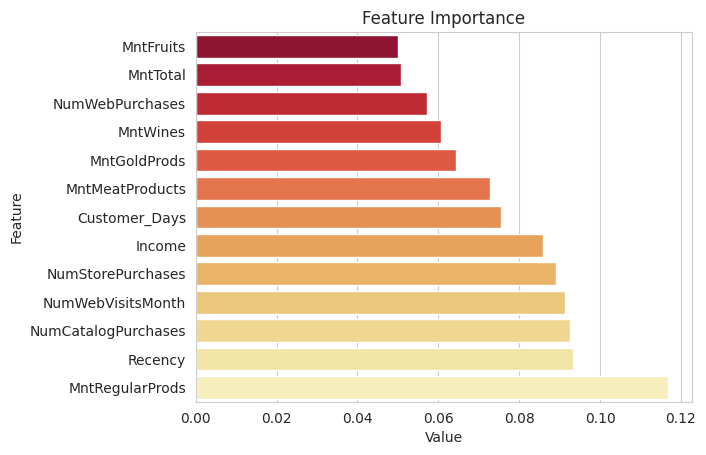

In [ ]:
feature_imp = pd.DataFrame({'Value':xgb_model.feature_importances_, 'Feature':x_train.columns})
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by = 'Value'), palette='YlOrRd_r')
plt.title('Feature Importance')

**Bayesian Optimization of Algorithm**

In [ ]:
# output of function needs to minimzied
# for a classification problem, were minimizing the accuracy
# so in theory, it's really just having a metric that calculates the accuracy
# then that accuracy is being maximzied in a bayesian fassion
def bayes_opt(n_estimators, subsample, learning_rate, max_depth, colsample_bytree, eta):

  folds     = 5
  skf       = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

  params_gbm                     = {}
  params_gbm['learning_rate']    = learning_rate
  params_gbm['n_estimators']     = int(n_estimators)
  # params_gbm['reg_lambda']       = reg_lambda
  # params_gbm['reg_alpha']        = reg_alpha
  # params_gbm['gamma']            = round(gamma)
  params_gbm['subsample']        = subsample
  params_gbm['max_depth']        = int(max_depth)
  params_gbm['colsample_bytree'] = colsample_bytree
  params_gbm['eta']              = eta


  weights      = class_weight.compute_sample_weight('balanced', y_train)

  scores       = []
  for fold, (train_idx, val_idx) in enumerate(skf.split(x_train, y_train)):

    x_train_fold, y_train_fold = pd.DataFrame(x_train).iloc[train_idx], pd.DataFrame(y_train).iloc[train_idx]
    x_val, y_val = pd.DataFrame(x_train).iloc[val_idx], pd.DataFrame(y_train).iloc[val_idx]
    watchlist = [(x_train_fold, y_train_fold), (x_val, y_val)]

    scorer     = make_scorer(log_loss)

    xgb_model  = XGBClassifier(**params_gbm,
                               objective = 'binary:logistic',
                               eval_metric = 'logloss')

    xgb_model.fit(x_train_fold, y_train_fold)

    val_preds  = xgb_model.predict_proba(x_val)
    score      = log_loss(y_val, val_preds)
    scores.append(score)



  scores = np.average(scores)


  # maximize 1- logloss (minimize logloss)

  return 1 - scores



pbounds = {'n_estimators': (100, 500),
          'subsample': (0.6, 1.0),
          'learning_rate':(0.01, 3),
           'max_depth': (3, 10),
           'colsample_bytree': (0.5, 1),
           'eta': (0.2, 0.4)
          }

optimizer   = BayesianOptimization(
    f       = bayes_opt,
    pbounds = pbounds,
    verbose = 2
)

optimizations = optimizer.maximize(
    init_points=4,
    n_iter=100,
)

**Increases Accuracy by 1% Doing Bayesian Optimization w/ 100 points**
1. The ranges of the parameters could also be something to consider... diabetes dataset was greatly influences by this

In [ ]:
xgb_model  = XGBClassifier(colsample_bytree = 0.7675, eta = 0.3081, learning_rate = 0.03232,
                          max_depth = 3, n_estimators = 298, subsample = 0.8004,
                           objective = 'binary:logistic', eval_metric = 'logloss')

xgb_model.fit(x_train, y_train)
predictions = xgb_model.predict(x_test)
accuracy_score(predictions, y_test)

0.8768115942028986

**Precision, Recall, F1 Score**

Precision: 0.75
Recall: 0.65
F1 Score: 0.68


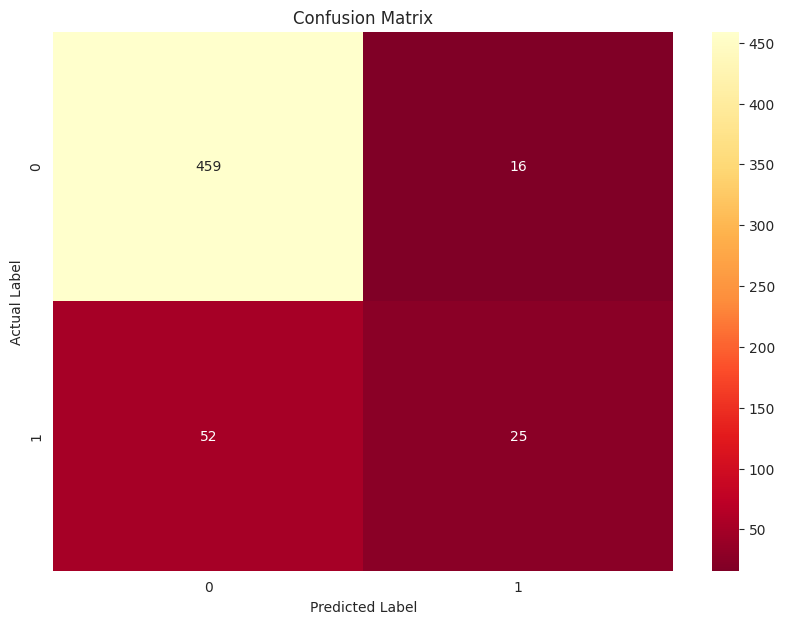

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predictions, average='macro')  # use 'micro' or 'weighted' based on your needs

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))

# Using seaborn to make it look better
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd_r")

plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


**Summary**

The following variables can be input into this model to determine whether or not a campaign strategy will be effective or not to a consumer.
1. Bought Amount of Fruits (Currency Unknown)
2. Number of Web Purchases (Non-in store purchase)
3. Bought Amount of Meat Products (Currency Unknown)
4. Bought Amount of Wines (Currency Unknown)
5. Number of Store Purchases
6. Annual Income (Unknown)
7. Total Amount of Purchases (Currency Unknown)
8. Number of Web Visits Per Month
9. Days a Customer Interacts with Store
10. Total Number of Catalogue Purchases
11. How recent the customer visited the store
12. Amount of Regular Products, Excluding one purchase category

---
An improvement to this model would be some feature engineering. A lot of these characteristics seem to be related to volume, both in terms of visits and overall money. The feature that model detected as the most important is actually a combination of all purchases, excluding one category (gold).


---
The store is already collecting 30 plus characteristics, so obtaining this information is not an issue. Inputting these characteristics into the model for each customer will return a prediction whether or not they will react positively to the campaign. I would test this model on the next X amount of customers and see how it performs. I suspect it will perform better than the blind campaigning that appears to be happening currently. Additionally, after a whole campaigning cycle has gone by, this model can be retrained if desired.
